# REINFORCE

I used some parts of the following code and the RL course at Aalto University:
https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py

In [1]:
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt
import gym

from ContinuousCartPole import ContinuousCartPoleEnv

%matplotlib inline

In [2]:
def discount_rewards(r, gamma):
    discounted_r = torch.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size(-1))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [3]:
class Policy(torch.nn.Module):
    def __init__(self, state_space, action_space, action_bound):
        super().__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.action_bound = action_bound
        self.hidden = 64
        self.fc1 = torch.nn.Linear(state_space, self.hidden)
        self.out_mean = torch.nn.Linear(self.hidden, self.action_space)
        self.out_sigma = torch.nn.Parameter(torch.tensor([1.0]))

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        mu = self.action_bound[0] * F.tanh(self.out_mean(x))
        sigma = F.softplus(self.out_sigma)
        return mu, sigma

    
class Agent(object):
    def __init__(self, policy):
        self.train_device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.policy = policy.to(self.train_device)
        self.optimizer = torch.optim.RMSprop(policy.parameters(), lr=1e-3)
        self.gamma = 0.98
        self.states = []
        self.action_probs = []
        self.rewards = []

    def episode_finished(self, episode_number):
        action_probs = torch.stack(self.action_probs, dim=0) \
                .to(self.train_device).squeeze(-1)
        rewards = torch.stack(self.rewards, dim=0).to(self.train_device).squeeze(-1)
        self.states, self.action_probs, self.rewards = [], [], []

        G = discount_rewards(rewards, self.gamma)
        G = (G - G.mean()) / (G.std() + 1e-9) #normalize discounted rewards
        loss = - (action_probs * G.detach()).mean()
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, observation, evaluation=False):
        x = torch.from_numpy(observation).float().to(self.train_device)
        mu, sigma = self.policy(x)
        dist = Normal(mu, sigma)
        if evaluation:
            return mu
        action = dist.sample()
        act_log_prob = dist.log_prob(action)
        return action, act_log_prob

    def store_outcome(self, observation, action_prob, reward):
        self.states.append(observation)
        self.action_probs.append(action_prob)
        self.rewards.append(torch.Tensor([reward]))

# Train

In [4]:
# Create a Gym environment
train_episodes = 10000
env = ContinuousCartPoleEnv()

In [5]:
env.action_space.low, env.action_space.high

(array([-1.]), array([1.]))

In [6]:
env.observation_space.shape

(4,)

action_space_dim:  1
observation_space_dim:  4


/home/isaac/miniconda3/envs/pytorch13/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 0 finished. Total reward: 9 (9 timesteps)
Episode 1 finished. Total reward: 7 (7 timesteps)
Episode 2 finished. Total reward: 17 (17 timesteps)
Episode 3 finished. Total reward: 9 (9 timesteps)
Episode 4 finished. Total reward: 9 (9 timesteps)
Episode 5 finished. Total reward: 19 (19 timesteps)
Episode 6 finished. Total reward: 8 (8 timesteps)
Episode 7 finished. Total reward: 12 (12 timesteps)
Episode 8 finished. Total reward: 6 (6 timesteps)
Episode 9 finished. Total reward: 9 (9 timesteps)
Episode 10 finished. Total reward: 8 (8 timesteps)
Episode 11 finished. Total reward: 9 (9 timesteps)
Episode 12 finished. Total reward: 14 (14 timesteps)
Episode 13 finished. Total reward: 11 (11 timesteps)
Episode 14 finished. Total reward: 14 (14 timesteps)
Episode 15 finished. Total reward: 8 (8 timesteps)
Episode 16 finished. Total reward: 12 (12 timesteps)
Episode 17 finished. Total reward: 11 (11 timesteps)
Episode 18 finished. Total reward: 7 (7 timesteps)
Episode 19 finished. Tota

Episode 156 finished. Total reward: 16 (16 timesteps)
Episode 157 finished. Total reward: 58 (58 timesteps)
Episode 158 finished. Total reward: 38 (38 timesteps)
Episode 159 finished. Total reward: 15 (15 timesteps)
Episode 160 finished. Total reward: 12 (12 timesteps)
Episode 161 finished. Total reward: 22 (22 timesteps)
Episode 162 finished. Total reward: 6 (6 timesteps)
Episode 163 finished. Total reward: 21 (21 timesteps)
Episode 164 finished. Total reward: 12 (12 timesteps)
Episode 165 finished. Total reward: 42 (42 timesteps)
Episode 166 finished. Total reward: 43 (43 timesteps)
Episode 167 finished. Total reward: 29 (29 timesteps)
Episode 168 finished. Total reward: 7 (7 timesteps)
Episode 169 finished. Total reward: 10 (10 timesteps)
Episode 170 finished. Total reward: 15 (15 timesteps)
Episode 171 finished. Total reward: 52 (52 timesteps)
Episode 172 finished. Total reward: 15 (15 timesteps)
Episode 173 finished. Total reward: 36 (36 timesteps)
Episode 174 finished. Total rewa

Episode 309 finished. Total reward: 30 (30 timesteps)
Episode 310 finished. Total reward: 32 (32 timesteps)
Episode 311 finished. Total reward: 79 (79 timesteps)
Episode 312 finished. Total reward: 7 (7 timesteps)
Episode 313 finished. Total reward: 16 (16 timesteps)
Episode 314 finished. Total reward: 70 (70 timesteps)
Episode 315 finished. Total reward: 38 (38 timesteps)
Episode 316 finished. Total reward: 41 (41 timesteps)
Episode 317 finished. Total reward: 11 (11 timesteps)
Episode 318 finished. Total reward: 56 (56 timesteps)
Episode 319 finished. Total reward: 84 (84 timesteps)
Episode 320 finished. Total reward: 40 (40 timesteps)
Episode 321 finished. Total reward: 28 (28 timesteps)
Episode 322 finished. Total reward: 12 (12 timesteps)
Episode 323 finished. Total reward: 21 (21 timesteps)
Episode 324 finished. Total reward: 21 (21 timesteps)
Episode 325 finished. Total reward: 41 (41 timesteps)
Episode 326 finished. Total reward: 48 (48 timesteps)
Episode 327 finished. Total re

Episode 461 finished. Total reward: 37 (37 timesteps)
Episode 462 finished. Total reward: 68 (68 timesteps)
Episode 463 finished. Total reward: 12 (12 timesteps)
Episode 464 finished. Total reward: 105 (105 timesteps)
Episode 465 finished. Total reward: 24 (24 timesteps)
Episode 466 finished. Total reward: 46 (46 timesteps)
Episode 467 finished. Total reward: 216 (216 timesteps)
Episode 468 finished. Total reward: 23 (23 timesteps)
Episode 469 finished. Total reward: 56 (56 timesteps)
Episode 470 finished. Total reward: 12 (12 timesteps)
Episode 471 finished. Total reward: 41 (41 timesteps)
Episode 472 finished. Total reward: 85 (85 timesteps)
Episode 473 finished. Total reward: 43 (43 timesteps)
Episode 474 finished. Total reward: 12 (12 timesteps)
Episode 475 finished. Total reward: 48 (48 timesteps)
Episode 476 finished. Total reward: 88 (88 timesteps)
Episode 477 finished. Total reward: 27 (27 timesteps)
Episode 478 finished. Total reward: 62 (62 timesteps)
Episode 479 finished. To

Episode 613 finished. Total reward: 41 (41 timesteps)
Episode 614 finished. Total reward: 126 (126 timesteps)
Episode 615 finished. Total reward: 166 (166 timesteps)
Episode 616 finished. Total reward: 209 (209 timesteps)
Episode 617 finished. Total reward: 41 (41 timesteps)
Episode 618 finished. Total reward: 121 (121 timesteps)
Episode 619 finished. Total reward: 15 (15 timesteps)
Episode 620 finished. Total reward: 7 (7 timesteps)
Episode 621 finished. Total reward: 74 (74 timesteps)
Episode 622 finished. Total reward: 23 (23 timesteps)
Episode 623 finished. Total reward: 93 (93 timesteps)
Episode 624 finished. Total reward: 143 (143 timesteps)
Episode 625 finished. Total reward: 87 (87 timesteps)
Episode 626 finished. Total reward: 55 (55 timesteps)
Episode 627 finished. Total reward: 43 (43 timesteps)
Episode 628 finished. Total reward: 108 (108 timesteps)
Episode 629 finished. Total reward: 161 (161 timesteps)
Episode 630 finished. Total reward: 47 (47 timesteps)
Episode 631 fini

Episode 767 finished. Total reward: 134 (134 timesteps)
Episode 768 finished. Total reward: 28 (28 timesteps)
Episode 769 finished. Total reward: 51 (51 timesteps)
Episode 770 finished. Total reward: 179 (179 timesteps)
Episode 771 finished. Total reward: 31 (31 timesteps)
Episode 772 finished. Total reward: 126 (126 timesteps)
Episode 773 finished. Total reward: 109 (109 timesteps)
Episode 774 finished. Total reward: 208 (208 timesteps)
Episode 775 finished. Total reward: 27 (27 timesteps)
Episode 776 finished. Total reward: 24 (24 timesteps)
Episode 777 finished. Total reward: 127 (127 timesteps)
Episode 778 finished. Total reward: 73 (73 timesteps)
Episode 779 finished. Total reward: 97 (97 timesteps)
Episode 780 finished. Total reward: 60 (60 timesteps)
Episode 781 finished. Total reward: 24 (24 timesteps)
Episode 782 finished. Total reward: 25 (25 timesteps)
Episode 783 finished. Total reward: 45 (45 timesteps)
Episode 784 finished. Total reward: 190 (190 timesteps)
Episode 785 fi

Episode 920 finished. Total reward: 66 (66 timesteps)
Episode 921 finished. Total reward: 80 (80 timesteps)
Episode 922 finished. Total reward: 90 (90 timesteps)
Episode 923 finished. Total reward: 18 (18 timesteps)
Episode 924 finished. Total reward: 41 (41 timesteps)
Episode 925 finished. Total reward: 134 (134 timesteps)
Episode 926 finished. Total reward: 149 (149 timesteps)
Episode 927 finished. Total reward: 127 (127 timesteps)
Episode 928 finished. Total reward: 46 (46 timesteps)
Episode 929 finished. Total reward: 57 (57 timesteps)
Episode 930 finished. Total reward: 182 (182 timesteps)
Episode 931 finished. Total reward: 134 (134 timesteps)
Episode 932 finished. Total reward: 77 (77 timesteps)
Episode 933 finished. Total reward: 106 (106 timesteps)
Episode 934 finished. Total reward: 116 (116 timesteps)
Episode 935 finished. Total reward: 65 (65 timesteps)
Episode 936 finished. Total reward: 239 (239 timesteps)
Episode 937 finished. Total reward: 86 (86 timesteps)
Episode 938 

Episode 1068 finished. Total reward: 231 (231 timesteps)
Episode 1069 finished. Total reward: 279 (279 timesteps)
Episode 1070 finished. Total reward: 52 (52 timesteps)
Episode 1071 finished. Total reward: 118 (118 timesteps)
Episode 1072 finished. Total reward: 58 (58 timesteps)
Episode 1073 finished. Total reward: 249 (249 timesteps)
Episode 1074 finished. Total reward: 10 (10 timesteps)
Episode 1075 finished. Total reward: 167 (167 timesteps)
Episode 1076 finished. Total reward: 213 (213 timesteps)
Episode 1077 finished. Total reward: 270 (270 timesteps)
Episode 1078 finished. Total reward: 138 (138 timesteps)
Episode 1079 finished. Total reward: 164 (164 timesteps)
Episode 1080 finished. Total reward: 25 (25 timesteps)
Episode 1081 finished. Total reward: 257 (257 timesteps)
Episode 1082 finished. Total reward: 286 (286 timesteps)
Episode 1083 finished. Total reward: 153 (153 timesteps)
Episode 1084 finished. Total reward: 223 (223 timesteps)
Episode 1085 finished. Total reward: 29

Episode 1214 finished. Total reward: 439 (439 timesteps)
Episode 1215 finished. Total reward: 69 (69 timesteps)
Episode 1216 finished. Total reward: 234 (234 timesteps)
Episode 1217 finished. Total reward: 255 (255 timesteps)
Episode 1218 finished. Total reward: 153 (153 timesteps)
Episode 1219 finished. Total reward: 138 (138 timesteps)
Episode 1220 finished. Total reward: 316 (316 timesteps)
Episode 1221 finished. Total reward: 170 (170 timesteps)
Episode 1222 finished. Total reward: 62 (62 timesteps)
Episode 1223 finished. Total reward: 209 (209 timesteps)
Episode 1224 finished. Total reward: 50 (50 timesteps)
Episode 1225 finished. Total reward: 391 (391 timesteps)
Episode 1226 finished. Total reward: 130 (130 timesteps)
Episode 1227 finished. Total reward: 153 (153 timesteps)
Episode 1228 finished. Total reward: 271 (271 timesteps)
Episode 1229 finished. Total reward: 18 (18 timesteps)
Episode 1230 finished. Total reward: 212 (212 timesteps)
Episode 1231 finished. Total reward: 13

Episode 1359 finished. Total reward: 222 (222 timesteps)
Episode 1360 finished. Total reward: 393 (393 timesteps)
Episode 1361 finished. Total reward: 58 (58 timesteps)
Episode 1362 finished. Total reward: 200 (200 timesteps)
Episode 1363 finished. Total reward: 486 (486 timesteps)
Episode 1364 finished. Total reward: 289 (289 timesteps)
Episode 1365 finished. Total reward: 227 (227 timesteps)
Episode 1366 finished. Total reward: 238 (238 timesteps)
Episode 1367 finished. Total reward: 316 (316 timesteps)
Episode 1368 finished. Total reward: 139 (139 timesteps)
Episode 1369 finished. Total reward: 124 (124 timesteps)
Episode 1370 finished. Total reward: 470 (470 timesteps)
Episode 1371 finished. Total reward: 345 (345 timesteps)
Episode 1372 finished. Total reward: 60 (60 timesteps)
Episode 1373 finished. Total reward: 212 (212 timesteps)
Episode 1374 finished. Total reward: 277 (277 timesteps)
Episode 1375 finished. Total reward: 120 (120 timesteps)
Episode 1376 finished. Total reward

Episode 1506 finished. Total reward: 249 (249 timesteps)
Episode 1507 finished. Total reward: 389 (389 timesteps)
Episode 1508 finished. Total reward: 211 (211 timesteps)
Episode 1509 finished. Total reward: 359 (359 timesteps)
Episode 1510 finished. Total reward: 166 (166 timesteps)
Episode 1511 finished. Total reward: 179 (179 timesteps)
Episode 1512 finished. Total reward: 576 (576 timesteps)
Episode 1513 finished. Total reward: 213 (213 timesteps)
Episode 1514 finished. Total reward: 175 (175 timesteps)
Episode 1515 finished. Total reward: 228 (228 timesteps)
Episode 1516 finished. Total reward: 68 (68 timesteps)
Episode 1517 finished. Total reward: 322 (322 timesteps)
Episode 1518 finished. Total reward: 304 (304 timesteps)
Episode 1519 finished. Total reward: 249 (249 timesteps)
Episode 1520 finished. Total reward: 173 (173 timesteps)
Episode 1521 finished. Total reward: 372 (372 timesteps)
Episode 1522 finished. Total reward: 370 (370 timesteps)
Episode 1523 finished. Total rewa

Episode 1651 finished. Total reward: 223 (223 timesteps)
Episode 1652 finished. Total reward: 231 (231 timesteps)
Episode 1653 finished. Total reward: 211 (211 timesteps)
Episode 1654 finished. Total reward: 133 (133 timesteps)
Episode 1655 finished. Total reward: 32 (32 timesteps)
Episode 1656 finished. Total reward: 330 (330 timesteps)
Episode 1657 finished. Total reward: 154 (154 timesteps)
Episode 1658 finished. Total reward: 241 (241 timesteps)
Episode 1659 finished. Total reward: 178 (178 timesteps)
Episode 1660 finished. Total reward: 463 (463 timesteps)
Episode 1661 finished. Total reward: 287 (287 timesteps)
Episode 1662 finished. Total reward: 404 (404 timesteps)
Episode 1663 finished. Total reward: 425 (425 timesteps)
Episode 1664 finished. Total reward: 154 (154 timesteps)
Episode 1665 finished. Total reward: 171 (171 timesteps)
Episode 1666 finished. Total reward: 194 (194 timesteps)
Episode 1667 finished. Total reward: 104 (104 timesteps)
Episode 1668 finished. Total rewa

Episode 1795 finished. Total reward: 176 (176 timesteps)
Episode 1796 finished. Total reward: 526 (526 timesteps)
Episode 1797 finished. Total reward: 156 (156 timesteps)
Episode 1798 finished. Total reward: 766 (766 timesteps)
Episode 1799 finished. Total reward: 58 (58 timesteps)
Episode 1800 finished. Total reward: 116 (116 timesteps)
Episode 1801 finished. Total reward: 426 (426 timesteps)
Episode 1802 finished. Total reward: 365 (365 timesteps)
Episode 1803 finished. Total reward: 526 (526 timesteps)
Episode 1804 finished. Total reward: 245 (245 timesteps)
Episode 1805 finished. Total reward: 239 (239 timesteps)
Episode 1806 finished. Total reward: 491 (491 timesteps)
Episode 1807 finished. Total reward: 133 (133 timesteps)
Episode 1808 finished. Total reward: 1.04e+03 (1041 timesteps)
Episode 1809 finished. Total reward: 783 (783 timesteps)
Episode 1810 finished. Total reward: 584 (584 timesteps)
Episode 1811 finished. Total reward: 101 (101 timesteps)
Episode 1812 finished. Tota

Episode 1937 finished. Total reward: 189 (189 timesteps)
Episode 1938 finished. Total reward: 141 (141 timesteps)
Episode 1939 finished. Total reward: 1.27e+03 (1269 timesteps)
Episode 1940 finished. Total reward: 3.06e+03 (3060 timesteps)
Episode 1941 finished. Total reward: 1.3e+03 (1301 timesteps)
Episode 1942 finished. Total reward: 146 (146 timesteps)
Episode 1943 finished. Total reward: 381 (381 timesteps)
Episode 1944 finished. Total reward: 486 (486 timesteps)
Episode 1945 finished. Total reward: 363 (363 timesteps)
Episode 1946 finished. Total reward: 853 (853 timesteps)
Episode 1947 finished. Total reward: 292 (292 timesteps)
Episode 1948 finished. Total reward: 691 (691 timesteps)
Episode 1949 finished. Total reward: 1.3e+03 (1300 timesteps)
Episode 1950 finished. Total reward: 965 (965 timesteps)
Episode 1951 finished. Total reward: 533 (533 timesteps)
Episode 1952 finished. Total reward: 1.5e+03 (1504 timesteps)
Episode 1953 finished. Total reward: 1.39e+03 (1392 timesteps

Episode 2076 finished. Total reward: 555 (555 timesteps)
Episode 2077 finished. Total reward: 530 (530 timesteps)
Episode 2078 finished. Total reward: 2.54e+03 (2543 timesteps)
Episode 2079 finished. Total reward: 426 (426 timesteps)
Episode 2080 finished. Total reward: 2.15e+03 (2151 timesteps)
Episode 2081 finished. Total reward: 659 (659 timesteps)
Episode 2082 finished. Total reward: 5.74e+03 (5739 timesteps)
Episode 2083 finished. Total reward: 8.01e+03 (8013 timesteps)
Episode 2084 finished. Total reward: 2.01e+03 (2007 timesteps)
Episode 2085 finished. Total reward: 1.23e+03 (1230 timesteps)
Episode 2086 finished. Total reward: 2.59e+03 (2590 timesteps)
Episode 2087 finished. Total reward: 322 (322 timesteps)
Episode 2088 finished. Total reward: 387 (387 timesteps)
Episode 2089 finished. Total reward: 721 (721 timesteps)
Episode 2090 finished. Total reward: 2.42e+03 (2419 timesteps)
Episode 2091 finished. Total reward: 349 (349 timesteps)
Episode 2092 finished. Total reward: 924

Episode 2212 finished. Total reward: 7.5e+03 (7503 timesteps)
Episode 2213 finished. Total reward: 1.06e+03 (1057 timesteps)
Episode 2214 finished. Total reward: 2.09e+03 (2093 timesteps)
Episode 2215 finished. Total reward: 2.41e+03 (2412 timesteps)
Episode 2216 finished. Total reward: 7.22e+03 (7215 timesteps)
Episode 2217 finished. Total reward: 2.01e+03 (2011 timesteps)
Episode 2218 finished. Total reward: 819 (819 timesteps)
Episode 2219 finished. Total reward: 2.31e+03 (2312 timesteps)
Episode 2220 finished. Total reward: 864 (864 timesteps)
Episode 2221 finished. Total reward: 72 (72 timesteps)
Episode 2222 finished. Total reward: 9.76e+03 (9760 timesteps)
Episode 2223 finished. Total reward: 6.22e+03 (6222 timesteps)
Episode 2224 finished. Total reward: 118 (118 timesteps)
Episode 2225 finished. Total reward: 2.07e+03 (2073 timesteps)
Episode 2226 finished. Total reward: 3.51e+03 (3506 timesteps)
Episode 2227 finished. Total reward: 7.24e+03 (7241 timesteps)
Episode 2228 finish

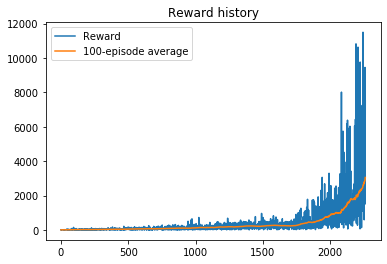

In [7]:

render = False

# Get dimensionalities of actions and observations
action_space_dim = env.action_space.shape[-1]
observation_space_dim = env.observation_space.shape[-1]
print('action_space_dim: ', action_space_dim)
print('observation_space_dim: ', observation_space_dim)

# Instantiate agent and its policy
policy = Policy(observation_space_dim, action_space_dim, env.action_space.high)
agent = Agent(policy)

# Arrays to keep track of rewards
reward_history, timestep_history = [], []
average_reward_history = []

# Run actual training
for episode_number in range(train_episodes):
    reward_sum, timesteps = 0, 0
    done = False
    # Reset the environment and observe the initial state
    observation = env.reset()

    # Loop until the episode is over
    while not done:
        # Get action from the agent
        action, action_probabilities = agent.get_action(observation)
        action = torch.clamp(action, env.action_space.low[0], env.action_space.high[0])
        previous_observation = observation

        # Perform the action on the environment, get new state and reward
        observation, reward, done, info = env.step(action.detach().cpu().numpy())

        # Store action's outcome (so that the agent can improve its policy)
        agent.store_outcome(previous_observation, action_probabilities, reward)

        if render:
            env.render()
            
        # Store total episode reward
        reward_sum += reward
        timesteps += 1


    print("Episode {} finished. Total reward: {:.3g} ({} timesteps)"
          .format(episode_number, reward_sum, timesteps))

    reward_history.append(reward_sum)
    timestep_history.append(timesteps)
    if episode_number > 100:
        avg = np.mean(reward_history[-100:])
    else:
        avg = np.mean(reward_history)
    average_reward_history.append(avg)

    agent.episode_finished(episode_number)
    
    if avg > 3000:
        print(f'Converged in episode {episode_number}')
        break

plt.plot(reward_history)
plt.plot(average_reward_history)
plt.legend(["Reward", "100-episode average"])
plt.title("Reward history")
plt.show()    

# Test

In [9]:
env = ContinuousCartPoleEnv()

In [ ]:
render = True
episodes = 1
test_reward, test_len = 0, 0
for ep in range(episodes):
    done = False
    observation = env.reset()
    while not done:
        # Similar to the training loop above -
        # get the action, act on the environment, save total reward
        # (evaluation=True makes the agent always return what it thinks to be
        # the best action - there is no exploration at this point)
#         print(observation)
        action = agent.get_action(observation, evaluation=True)
        observation, reward, done, info = env.step(action.detach().cpu().numpy())

        if render:
            env.render()
        test_reward += reward
        test_len += 1
print("Average test reward:", test_reward/episodes, "episode length:", test_len/episodes)
